## Tool to extract usefull information from mlperf trace

In [1]:
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import json
import os
import seaborn as sns
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figsize=(10, 5)
font=10

plt.figure(dpi=600)
plt.rc('xtick', labelsize=font) 
plt.rc('font', size=font)
sns.set(font_scale=1.4, style="whitegrid");

<Figure size 3600x2400 with 0 Axes>

In [2]:
def trace_to_df(fname):
    with open(fname, "r") as f:
        j = json.load(f)
    if type(j) == dict:
        j = j['traceEvents']
        
    result = []
    for item in j:
        name = item['name']
        if name not in ["Latency", "Sample", "QuerySamplesComplete", "IssueQuery"]:
            continue

        args = item.get('args')
        d = {"ts": item['ts'], "name": name, "dur": item.get("dur")}

        if name == "Latency":
            d["issue_delay"] = args["issue_delay"]
            d["issue_to_done"] = args["issue_to_done"] / 1e3
            result.append(d)
        elif name == "Sample":
            if args:
                d["issue_start_ns"] = args["issue_start_ns"]
                d["complete_ns"] = args["complete_ns"]
                d["issue_to_done"] = (args["complete_ns"] - args["issue_start_ns"]) / 1e3
                result.append(d)
        elif name == "QuerySamplesComplete":
            result.append(d)
        elif name == "IssueQuery":
            result.append(d)

    df = pd.DataFrame(result)
    df = df.sort_values(by=["ts"])
    return df

BINS = 10

In [3]:
df = trace_to_df('/tmp/mlperf_log_trace.json')
df.describe()

,ts,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
count,2.000000e+04,10000.000000,5.000000e+03,10000.000000,5.000000e+03,5.000000e+03
mean,4.894584e+07,17.731682,7.001508e+04,6112.554491,7.001508e+04,6.182570e+06
std,2.839099e+07,25.578639,9.666462e+04,2254.077235,9.666462e+04,2.263719e+06
min,4.102560e+03,1.152000,8.810000e+02,2754.967000,8.810000e+02,2.780383e+06
25%,2.463025e+07,3.974750,5.806250e+04,4100.473000,5.806250e+04,4.166623e+06
50%,4.881766e+07,7.364000,6.159800e+04,6089.880000,6.159800e+04,6.155939e+06
75%,7.373552e+07,27.441000,6.835175e+04,7337.257000,6.835175e+04,7.408272e+06
max,9.832065e+07,508.552000,6.522433e+06,22234.101000,6.522433e+06,2.414005e+07


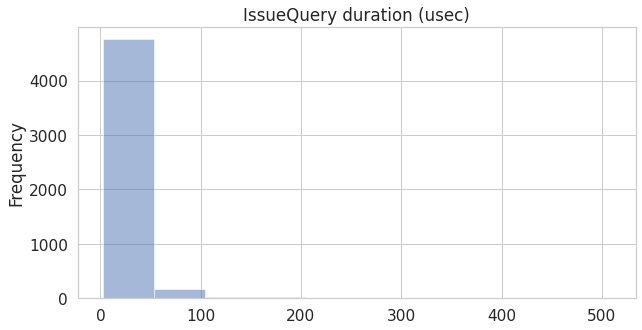

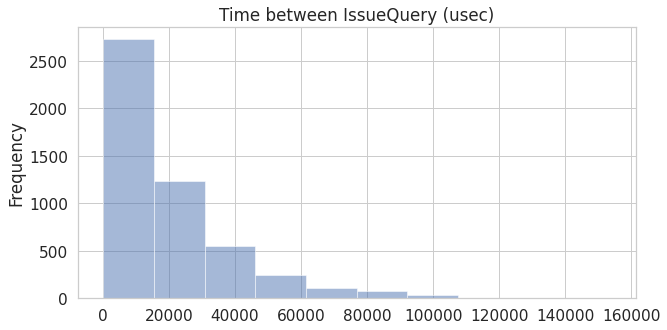

In [4]:
df1 = df[df["name"].isin(["IssueQuery"])]
df1['delta'] = df1['ts'].diff()
ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('IssueQuery duration (usec)');
plt.show()
ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Time between IssueQuery (usec)');

# df1['delta'].describe()

In [5]:
# for SingleStream
if False:
    df1 = df[df["name"].isin(["QuerySamplesComplete"])]
    ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    ax.set_title('Inference time (usec)');
    plt.show()
    ax = df1['dur'].plot(figsize=figsize)
    ax.set(ylim=(0, 100))
    ax.set_title('Individual inference time (usec)');

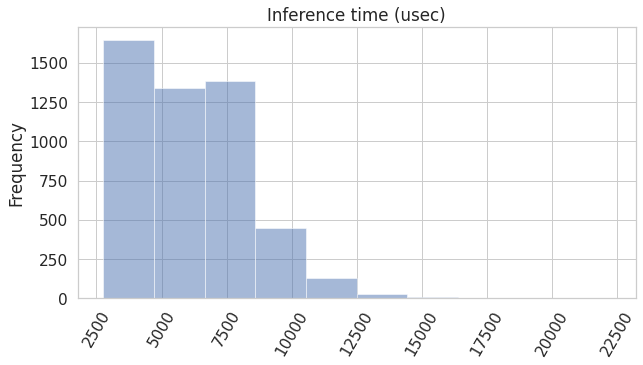

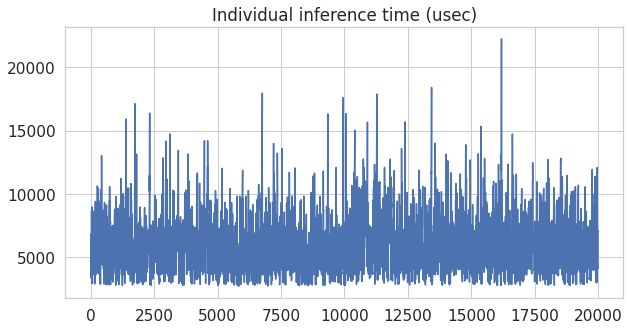

In [6]:
df1 = df[df["name"].isin(["Latency"])]
ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Inference time (usec)');
#ax.set(xlim=(0, 25000))
plt.xticks(rotation=60)
plt.show()

ax = df1['issue_to_done'].plot(figsize=figsize)
ax.set_title('Individual inference time (usec)');
#ax.set(ylim=(0, 200))
plt.show()


# df1['issue_to_done'].describe()

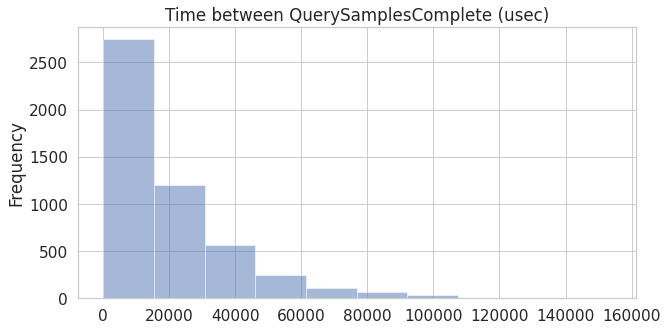

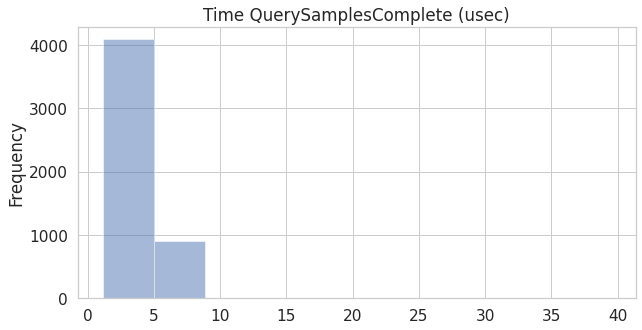

In [7]:
df1 = df[df["name"].isin(["QuerySamplesComplete"])]
df1['delta'] = df1['ts'].diff()
ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Time between QuerySamplesComplete (usec)');
plt.show()

ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
ax.set_title('Time QuerySamplesComplete (usec)');